
# 🏗️ 02 - Feature Engineering for BTC/USDT

**Objective:**  
This notebook will help you create **new features** from your raw BTC/USDT data. By adding technical indicators (moving averages, RSI, etc.), time-based features (day of week, hour), and other transformations, you can give your AI model richer information to improve predictive accuracy.

---

## ❓ Why Feature Engineering?

1. **Enhances Predictive Power**:  
   Indicators often highlight trends or momentum that raw `open/high/low/close` data might not show explicitly.

2. **Captures Patterns**:  
   Rolling features, time-of-day insights, or volume spikes can reveal recurring intraday behavior.

3. **Improves Model Training**:  
   Better features can yield better results than just raw OHLC data alone.

---

## 🔧 What This Notebook Does

1. **Loads Data**: Reads your CSV and prepares for feature creation.
2. **Time Features**: (Day of week, hour of day, etc.)
3. **Technical Indicators**: (Moving Averages, RSI, Bollinger Bands, MACD, etc.)
4. **Lagged & Rate of Change**: (Helps capture short-term trends.)
5. **Save**: Exports a new CSV (e.g., `BTCUSDT_1m_features.csv`) containing all your new columns.

---

## 🛠️ What Might Be Missing or Next Steps

- **More advanced indicators**: (like advanced candle pattern detection, Heikin-Ashi transforms).
- **Custom domain knowledge**: If you have special domain insights, integrate them.
- **Feature selection**: Some features may not improve the model, so you'll test them in `03_model_training.ipynb`.

Let's begin!


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load your raw BTC data
df = pd.read_csv('../data/BTCUSDT_1m.csv')

# 2) Convert 'open_time' to datetime and set as index
df['open_time'] = pd.to_datetime(df['open_time'])
df.set_index('open_time', inplace=True)

# 3) Convert numeric columns
numeric_cols = ['open', 'high', 'low', 'close', 'volume']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("Data loaded. Here are the first 5 rows:")
df.head()


Data loaded. Here are the first 5 rows:


,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_volume,taker_buy_quote_volume
open_time,,,,,,,,,,
2024-01-01 00:00:00,42283.58,42298.62,42261.02,42298.61,35.92724,2024-01-01 00:00:59.999,1.519032e+06,1327,23.18766,9.803947e+05
2024-01-01 00:01:00,42298.62,42320.00,42298.61,42320.00,21.16779,2024-01-01 00:01:59.999,8.955809e+05,1348,13.47483,5.700808e+05
2024-01-01 00:02:00,42319.99,42331.54,42319.99,42325.50,21.60391,2024-01-01 00:02:59.999,9.143711e+05,1019,11.21801,4.747986e+05
2024-01-01 00:03:00,42325.50,42368.00,42325.49,42367.99,30.50730,2024-01-01 00:03:59.999,1.291997e+06,1241,24.04878,1.018449e+06
2024-01-01 00:04:00,42368.00,42397.23,42367.99,42397.23,46.05107,2024-01-01 00:04:59.999,1.951945e+06,1415,34.12804,1.446539e+06



## 🗓️ 1. Time-Based Features

**Why?**  
Certain markets exhibit patterns depending on the hour of the day or day of the week (for example, higher volatility on Mondays or at certain times).


In [2]:

# Extract Day of Week (Mon=0, Sun=6)
df['day_of_week'] = df.index.dayofweek

# Extract Hour of Day (0-23)
df['hour_of_day'] = df.index.hour

print("Added 'day_of_week' and 'hour_of_day' columns.")
df[['day_of_week','hour_of_day']].head(10)


Added 'day_of_week' and 'hour_of_day' columns.


,day_of_week,hour_of_day
open_time,,
2024-01-01 00:00:00,0,0
2024-01-01 00:01:00,0,0
2024-01-01 00:02:00,0,0
2024-01-01 00:03:00,0,0
2024-01-01 00:04:00,0,0
2024-01-01 00:05:00,0,0
2024-01-01 00:06:00,0,0
2024-01-01 00:07:00,0,0
2024-01-01 00:08:00,0,0



## 📈 2. Technical Indicators

**Why?**  
Technical indicators can reveal trends or momentum in price data. Common ones:

- **Moving Average (MA)**: Smooths short-term fluctuations.
- **Exponential Moving Average (EMA)**: Similar to MA but gives more weight to recent data.
- **Relative Strength Index (RSI)**: Measures speed and change of price movements.
- **Bollinger Bands**: Measures volatility using a moving average and std dev.

**Below**, we’ll generate a few basic indicators. Feel free to add or remove as needed.


In [3]:

# Simple Moving Average (MA) - 14 periods
df['ma_14'] = df['close'].rolling(window=14).mean()

# Exponential Moving Average (EMA) - 14 periods
df['ema_14'] = df['close'].ewm(span=14, adjust=False).mean()

# Bollinger Bands (20 periods, 2 std dev)
ma_20 = df['close'].rolling(window=20).mean()
std_20 = df['close'].rolling(window=20).std()
df['bb_upper'] = ma_20 + 2 * std_20
df['bb_lower'] = ma_20 - 2 * std_20

# RSI calculation (14 periods)
# Step 1: Price changes (delta)
delta = df['close'].diff()
# Step 2: Gains/Losses
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
# Step 3: Average gain/loss
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
# Step 4: RS & RSI
rs = avg_gain / avg_loss
df['rsi_14'] = 100 - (100 / (1 + rs))

print("Added MA(14), EMA(14), Bollinger Bands, and RSI(14).")
df[['close','ma_14','ema_14','bb_upper','bb_lower','rsi_14']].tail(10)


Added MA(14), EMA(14), Bollinger Bands, and RSI(14).


,close,ma_14,ema_14,bb_upper,bb_lower,rsi_14
open_time,,,,,,
2024-01-30 23:51:00,42844.30,42813.044286,42838.212010,43013.386102,42695.632898,46.762975
2024-01-30 23:52:00,42885.21,42814.275714,42844.478409,42993.901425,42703.919575,51.555901
2024-01-30 23:53:00,42877.26,42815.063571,42848.849287,42970.826124,42714.937876,50.984417
2024-01-30 23:54:00,42920.16,42818.647857,42858.357382,42964.167891,42718.394109,54.185992
2024-01-30 23:55:00,42903.70,42829.498571,42864.403065,42951.831915,42724.990085,65.262735
2024-01-30 23:56:00,42944.52,42838.313571,42875.085323,42957.012253,42722.152747,63.152510
2024-01-30 23:57:00,42931.61,42848.875000,42882.621946,42965.659923,42718.848077,66.624691
2024-01-30 23:58:00,42953.51,42860.696429,42892.073687,42979.266260,42713.795740,67.898084
2024-01-30 23:59:00,42941.10,42873.107143,42898.610529,42989.417405,42711.131595,69.131670



## ⏮️ 3. Lagged Features

**Why?**  
Lagging your price or volume by 1 or more steps can help the model see recent history as direct inputs. For instance, `close_lag1` is yesterday's close (if you have daily data) or last minute's close (in your case).

We'll create a 1-bar lagged close, 2-bar, etc. Usually 1 to 3 lags are quite common.


In [4]:

# 1-bar lag of close price
df['close_lag1'] = df['close'].shift(1)

# 2-bar lag
df['close_lag2'] = df['close'].shift(2)

# You can add more, but let's keep it simple for now
print("Lagged features added (close_lag1, close_lag2).")
df[['close','close_lag1','close_lag2']].head(10)


Lagged features added (close_lag1, close_lag2).


,close,close_lag1,close_lag2
open_time,,,
2024-01-01 00:00:00,42298.61,NaN,NaN
2024-01-01 00:01:00,42320.00,42298.61,NaN
2024-01-01 00:02:00,42325.50,42320.00,42298.61
2024-01-01 00:03:00,42367.99,42325.50,42320.00
2024-01-01 00:04:00,42397.23,42367.99,42325.50
2024-01-01 00:05:00,42409.20,42397.23,42367.99
2024-01-01 00:06:00,42423.95,42409.20,42397.23
2024-01-01 00:07:00,42414.45,42423.95,42409.20
2024-01-01 00:08:00,42420.07,42414.45,42423.95



## 🔄 4. Rate of Change (RoC) or Returns

**Why?**  
Percentage change captures momentum. If returns are consistently above 0, the trend is bullish. If returns are < 0 frequently, it may be bearish.


In [5]:

# We already had a 'returns' in the exploration notebook, but let's do it again for clarity
df['returns_1m'] = df['close'].pct_change()

print("Created 'returns_1m' to capture minute-to-minute returns.")
df[['close','returns_1m']].tail(10)


Created 'returns_1m' to capture minute-to-minute returns.


,close,returns_1m
open_time,,
2024-01-30 23:51:00,42844.30,0.000775
2024-01-30 23:52:00,42885.21,0.000955
2024-01-30 23:53:00,42877.26,-0.000185
2024-01-30 23:54:00,42920.16,0.001001
2024-01-30 23:55:00,42903.70,-0.000384
2024-01-30 23:56:00,42944.52,0.000951
2024-01-30 23:57:00,42931.61,-0.000301
2024-01-30 23:58:00,42953.51,0.000510
2024-01-30 23:59:00,42941.10,-0.000289



## 👀 5. Quick Visualization of Some Indicators

Let's do a small plot to see if the features make sense.


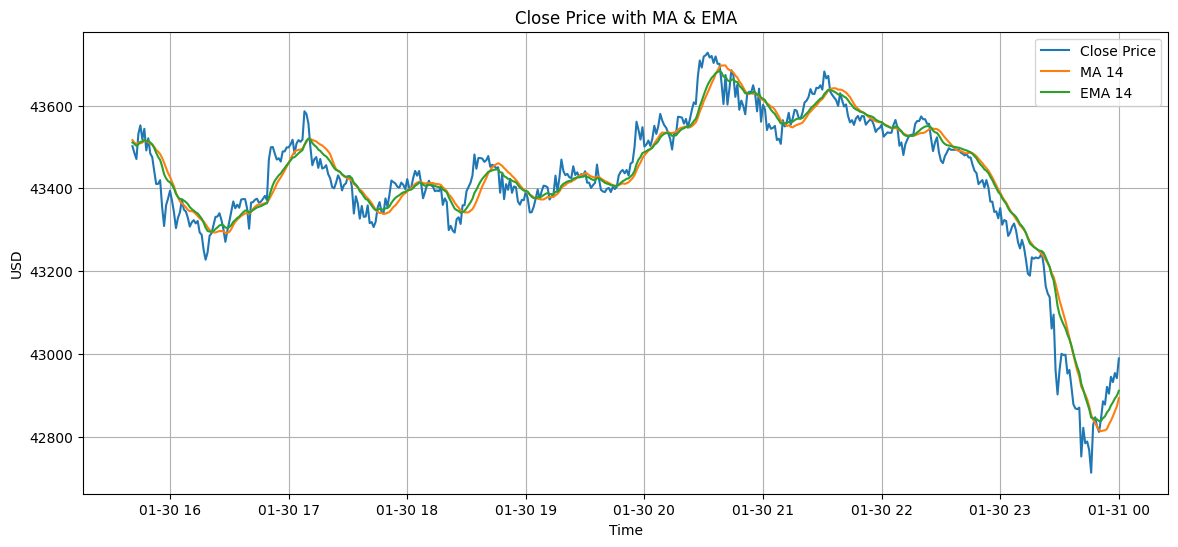

In [6]:

import matplotlib.dates as mdates

# Just plot the last X minutes for readability
df_plot = df.iloc[-500:]  # last 500 bars

fig, ax = plt.subplots(figsize=(14,6))

ax.plot(df_plot.index, df_plot['close'], label='Close Price')
ax.plot(df_plot.index, df_plot['ma_14'], label='MA 14')
ax.plot(df_plot.index, df_plot['ema_14'], label='EMA 14')

ax.set_title('Close Price with MA & EMA')
ax.set_xlabel('Time')
ax.set_ylabel('USD')
ax.legend()
plt.grid(True)
plt.show()


In [7]:
##2025-04-19

import ta  # technical analysis library

# 1. MACD
df['macd'] = ta.trend.macd(df['close'])
df['macd_signal'] = ta.trend.macd_signal(df['close'])

# 2. Bollinger Band Width
df['bb_width'] = (ta.volatility.BollingerBands(df['close']).bollinger_hband() - 
                  ta.volatility.BollingerBands(df['close']).bollinger_lband())

# 3. Average True Range (ATR)
df['atr'] = ta.volatility.AverageTrueRange(
    high=df['high'], 
    low=df['low'], 
    close=df['close']
).average_true_range()

# 4. Stochastic Oscillator
df['stoch_k'] = ta.momentum.StochasticOscillator(
    high=df['high'], 
    low=df['low'], 
    close=df['close']
).stoch()

df['stoch_d'] = ta.momentum.StochasticOscillator(
    high=df['high'], 
    low=df['low'], 
    close=df['close']
).stoch_signal()

print("New features added!")

New features added!



## 💾 6. Save the New DataFrame

We'll save this enhanced DataFrame to a new CSV, so we can use it later in model training (`03_model_training.ipynb`).


In [8]:

output_csv = '../data/BTCUSDT_1m_features.csv'
df.to_csv(output_csv)
print(f"Features saved to {output_csv}")


Features saved to ../data/BTCUSDT_1m_features.csv



## 🏁 Conclusion & Next Steps

You have now created:

- **Time-based features** (day_of_week, hour_of_day)
- **Technical indicators** (MA, EMA, Bollinger Bands, RSI)
- **Lagged features** (close_lag1, close_lag2)
- **Rate of Change** or returns

**Next Steps**:
1. Inspect correlation between these features and future price movement.
2. Move on to your **03_model_training.ipynb**, where you'll:
   - Load `BTCUSDT_1m_features.csv`
   - Split data into train/test
   - Train a baseline model (like a Decision Tree or Random Forest)
   - Evaluate results

**What could be missing or improved?**
- More advanced indicators (MACD, Ichimoku, etc.).
- More lags, or different intervals (5m, 15m).
- Filtering or smoothing data (for example, outlier removal).
- Considering bigger timeframe to label future targets (e.g. close price 15 minutes ahead).

_Feature engineering is an iterative process: keep experimenting!_
